In [87]:
import pandas as pd
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import librosa
import resampy
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib


In [88]:
# Load the dataset
df = pd.read_csv('cv-valid-train1.csv')

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   filename    2000 non-null   object 
 1   up_votes    2000 non-null   int64  
 2   down_votes  2000 non-null   int64  
 3   age         732 non-null    object 
 4   gender      736 non-null    object 
 5   accent      629 non-null    object 
 6   duration    0 non-null      float64
dtypes: float64(1), int64(2), object(4)
memory usage: 109.5+ KB


In [90]:
df.head()

,filename,up_votes,down_votes,age,gender,accent,duration
0,sample-000000.mp3,1,0,NaN,NaN,NaN,NaN
1,sample-000001.mp3,1,0,NaN,NaN,NaN,NaN
2,sample-000002.mp3,1,0,NaN,NaN,NaN,NaN
3,sample-000003.mp3,1,0,NaN,NaN,NaN,NaN
4,sample-000004.mp3,3,2,NaN,NaN,NaN,NaN


In [91]:
#Unique Values from Data
df.gender.unique


<bound method Series.unique of 0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1995    male
1996    male
1997    male
1998     NaN
1999     NaN
Name: gender, Length: 2000, dtype: object>

In [92]:
# Handle missing values
df = df.dropna(subset=['age', 'gender', 'accent'])

In [93]:
# Load audio data and extract features
def load_and_extract_features(row, base_directory="cv-valid-train"):
    file_path = os.path.join(base_directory, row['filename'])
    print(f"Loading file: {file_path}")
    try:
        audio_data, _ = librosa.load(file_path, res_type='kaiser_fast')
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio_data, sr=22050, n_mfcc=13)
        # Pad or truncate to a fixed length (e.g., 100 frames)
        mfccs_padded = pad_sequences([mfccs.T], maxlen=100, padding='post', truncating='post')[0].T
        return mfccs_padded
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

In [94]:
df['features'] = df.apply(load_and_extract_features, axis=1)

Loading file: cv-valid-train\sample-000013.mp3
Loading file: cv-valid-train\sample-000014.mp3


Loading file: cv-valid-train\sample-000019.mp3
Loading file: cv-valid-train\sample-000020.mp3
Loading file: cv-valid-train\sample-000023.mp3
Loading file: cv-valid-train\sample-000026.mp3
Loading file: cv-valid-train\sample-000027.mp3
Loading file: cv-valid-train\sample-000029.mp3
Loading file: cv-valid-train\sample-000034.mp3
Loading file: cv-valid-train\sample-000036.mp3
Loading file: cv-valid-train\sample-000039.mp3
Loading file: cv-valid-train\sample-000044.mp3
Loading file: cv-valid-train\sample-000047.mp3
Loading file: cv-valid-train\sample-000049.mp3
Loading file: cv-valid-train\sample-000051.mp3
Loading file: cv-valid-train\sample-000053.mp3
Loading file: cv-valid-train\sample-000054.mp3
Loading file: cv-valid-train\sample-000056.mp3
Loading file: cv-valid-train\sample-000059.mp3
Loading file: cv-valid-train\sample-000065.mp3
Loading file: cv-valid-train\sample-000068.mp3
Loading file: cv-valid-train\sample-000072.mp3
Loading file: cv-valid-train\sample-000073.mp3
Loading file:

In [95]:
# Drop rows with missing or failed audio loading
df = df.dropna(subset=['features'])

In [96]:
# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(
    np.stack(df['features']), df['gender'].values, test_size=0.2, random_state=42
)

In [97]:
# Label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)


In [98]:
# Save the label encoder to a file
label_encoder_filename = 'label_encoder.joblib'
joblib.dump(label_encoder, label_encoder_filename)

['label_encoder.joblib']

In [99]:
# Model building (example CNN)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(np.unique(y_train_encoded).size, activation='softmax')  # Adjust output neurons based on your classes
])

In [100]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [101]:
# Model training
model.fit(X_train, y_train_encoded, epochs=10, validation_data=(X_val, y_val_encoded))

Epoch 1/10
16/16 [==============================] - 1s 18ms/step - loss: 22.0550 - accuracy: 0.6352 - val_loss: 11.9001 - val_accuracy: 0.7073
Epoch 2/10
16/16 [==============================] - 0s 5ms/step - loss: 7.4844 - accuracy: 0.7152 - val_loss: 7.1574 - val_accuracy: 0.6423
Epoch 3/10
16/16 [==============================] - 0s 5ms/step - loss: 3.8362 - accuracy: 0.7889 - val_loss: 5.4743 - val_accuracy: 0.7317
Epoch 4/10
16/16 [==============================] - 0s 5ms/step - loss: 2.3425 - accuracy: 0.8012 - val_loss: 4.9303 - val_accuracy: 0.7073
Epoch 5/10
16/16 [==============================] - 0s 5ms/step - loss: 1.2069 - accuracy: 0.8484 - val_loss: 4.9877 - val_accuracy: 0.7073
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 1.0421 - accuracy: 0.8750 - val_loss: 4.8087 - val_accuracy: 0.7561
Epoch 7/10
16/16 [==============================] - 0s 4ms/step - loss: 0.4911 - accuracy: 0.8975 - val_loss: 4.5494 - val_accuracy: 0.6504
Epoch 8/10
16/16 

In [102]:
# Evaluate model on validation set
loss, accuracy = model.evaluate(X_val, y_val_encoded)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

4/4 [==============================] - 0s 2ms/step - loss: 4.9199 - accuracy: 0.6260
Validation Loss: 4.919851303100586, Validation Accuracy: 0.6260162591934204


Epoch 1/10
16/16 [==============================] - 0s 8ms/step - loss: 0.2446 - accuracy: 0.9365 - val_loss: 4.2265 - val_accuracy: 0.7073
Epoch 2/10
16/16 [==============================] - 0s 5ms/step - loss: 0.1134 - accuracy: 0.9631 - val_loss: 4.2708 - val_accuracy: 0.6992
Epoch 3/10
16/16 [==============================] - 0s 5ms/step - loss: 0.1036 - accuracy: 0.9754 - val_loss: 4.5091 - val_accuracy: 0.6992
Epoch 4/10
16/16 [==============================] - 0s 5ms/step - loss: 0.2119 - accuracy: 0.9529 - val_loss: 4.0020 - val_accuracy: 0.7398
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.1825 - accuracy: 0.9488 - val_loss: 4.6676 - val_accuracy: 0.6667
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.1725 - accuracy: 0.9529 - val_loss: 4.3618 - val_accuracy: 0.6585
Epoch 7/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0706 - accuracy: 0.9754 - val_loss: 3.9731 - val_accuracy: 0.7317
Epoch 8/10
16/16 [==

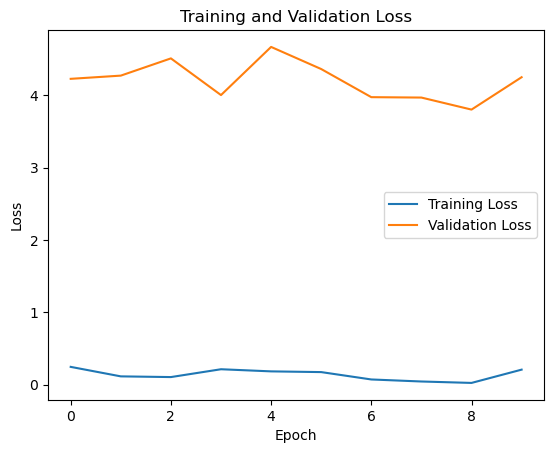

In [103]:
import matplotlib.pyplot as plt

# Assuming you have the history object from training the model
history = model.fit(X_train, y_train_encoded, epochs=10, validation_data=(X_val, y_val_encoded))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [114]:
# Assuming you have a function to extract features from new audio files
def extract_features_from_audio(file_path):
    audio_data, _ = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio_data, sr=22050, n_mfcc=13)
    mfccs_padded = pad_sequences([mfccs.T], maxlen=100, padding='post', truncating='post')[0].T
    return mfccs_padded

# Path to a new audio file
new_audio_file_path = "cv-valid-train\sample-000013.mp3"

# Extract features from the new audio file
new_data_features = extract_features_from_audio(new_audio_file_path)

# Reshape the features to match the input shape of the model
new_data_features = np.expand_dims(new_data_features, axis=0)

# Make predictions on the new data
predictions = model.predict(new_data_features)

# Decode predictions to get class labels
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

print(f"Predicted gender: {predicted_labels[0]}")


1/1 [==============================] - 0s 19ms/step
Predicted gender: female


In [106]:
# Save the trained model
model.save('model.h5')

C:\Users\91961\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [107]:
# Save the label encoder classes
np.save('label_encoder_classes.npy', label_encoder.classes_)